In [1]:
import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt
import torchattacks
import os
torch.set_default_dtype(torch.float32)


from astro_dataset import *
from linear_atomic import *
from utilities import *
from fgsm_attacks import *
from pgd_attack import *

Repeat for a more common dataset
* Trust the training acc & compare and adv attacks.
* CIFAR-10



More Attacks

* DeepFool
* 2nd most probable class?
* ....

#### Code used to train the models [kept for reference]

In [2]:
#nfeatures, nclasses, train_loader, test_loader = get_astro_data(train_batch=200, test_batch=200)
#print(len(train_loader))
#print(len(test_loader))
#timer = Timer()
#timer.start()
#losses = np.array([])
#accuracies = np.array([])
#nmodels = 200
#for i in range(nmodels):
#    model, loss, accuracy = train_new_model(
#        atomics=True, 
#        nfeatures=nfeatures, nclasses=nclasses, nhidden=5*nfeatures,  
#        train_loader = train_loader, test_loader = test_loader,
#        )

#    torch.save(model.state_dict(), f"atomic_models/model_{i}.pth")
#    losses=np.append(losses,loss)
#   accuracies=np.append(accuracies,accuracy)
#    np.save("atomic_models/losses.npy", losses)
#    np.save("atomic_models/accuracies.npy", accuracies)
#timer.pstop()

In [3]:
#timer = Timer()
#timer.start()
#model, loss, accuracy = train_new_model(
#    atomics=False, 
#    nfeatures=nfeatures, nclasses=nclasses, nhidden=5*nfeatures,  
#    train_loader = train_loader, test_loader = test_loader,
#    )

#torch.save(model.state_dict(), f"atomic_models/model.pth")
#timer.pstop()

### Load models & Continue

In [2]:
nfeatures, nclasses, train_loader, test_loader = get_astro_data(train_batch=200, test_batch=1)
print(nfeatures, nclasses)
num_epochs = 25
num_models = 200
losses = np.load("atomic_models/losses.npy")
accuracies = np.load("atomic_models/accuracies.npy")
models=[]
for i in range(num_models):
    model = Classifier(atomics=True,nfeatures=nfeatures, nclasses=nclasses, nhidden=5*nfeatures)
    model.load_state_dict(torch.load(f"atomic_models/model_{i}.pth"))
    model.eval()
    models.append(model)
losses = np.reshape(losses, (num_models,num_epochs))
accuracies = np.reshape(accuracies, (num_models,num_epochs))

8 3


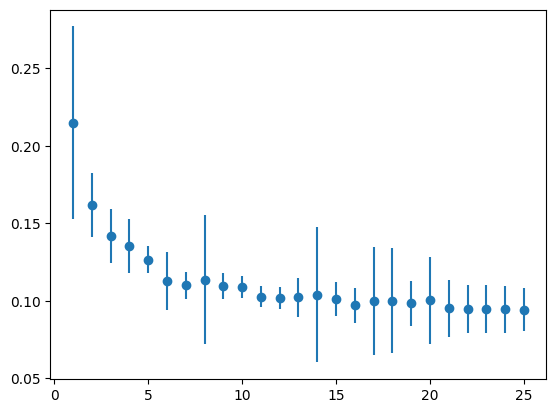

In [3]:
plt.errorbar(list(range(1,num_epochs+1)), np.mean(losses,axis=0), np.std(losses,axis=0),linestyle="None",marker="o")
plt.show()

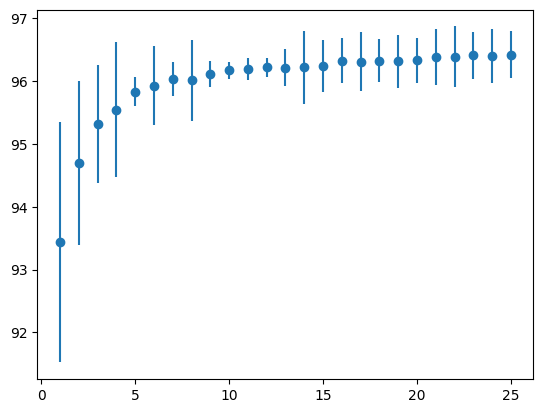

In [4]:
plt.errorbar(list(range(1,num_epochs+1)), np.mean(accuracies,axis=0), np.std(accuracies,axis=0),linestyle="None",marker="o")
plt.show()

In [5]:
for model in models[:3]:
    cor, total = test(model, test_loader)
    print(f"{cor*100/total} % accuracy")

96.504 % accuracy
96.444 % accuracy
96.612 % accuracy


## PGD Attack

In [6]:
print("Atomic model")
timer = Timer()
timer.start()
model = Classifier(atomics=False,
                              nfeatures=nfeatures, nclasses=nclasses, nhidden=5*nfeatures,  )
model.load_state_dict(torch.load(f"atomic_models/model.pth"))
model.eval()
print(test(model,test_loader))
print(pgd_attack(model, test_loader, torch.nn.CrossEntropyLoss(), 0.01, 0.01, 10))
timer.pstop()

print("non-atomic model")
timer = Timer()
timer.start()
print(pgd_attack(models[0], test_loader, torch.nn.CrossEntropyLoss(), 0.01, 0.01, 10))
timer.pstop()

print("non-atomic model")
timer = Timer()
timer.start()
print(pgd_attack(models[111], test_loader, torch.nn.CrossEntropyLoss(), 0.01, 0.01, 10))
timer.pstop()

Atomic model
(24131, 25000)


/home/cculver/anaconda3/envs/generalml/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


22913
Elapsed time: 100.2287 seconds
non-atomic model
22919
Elapsed time: 181.4436 seconds
non-atomic model
22959
Elapsed time: 174.2036 seconds


## FSGM Attack

#### Attack runs

In [12]:
def run_fgsm(epsilon, deterministic_training=True, deterministic_inference=True):
    models = []
    if deterministic_training:
        if deterministic_inference:
            model = Classifier(atomics=deterministic_inference,
                              nfeatures=nfeatures, nclasses=nclasses, nhidden=5*nfeatures,  )
            model.load_state_dict(torch.load(f"atomic_models/model.pth"))
            model.eval()
            models.append(model)
        else:
            for i in range(num_models):
                
                model = Classifier(atomics=deterministic_inference,
                                  nfeatures=nfeatures, nclasses=nclasses, nhidden=5*nfeatures,  )
                model.load_state_dict(torch.load(f"atomic_models/model.pth"))
                model.eval()
                models.append(model)
    else:
        for i in range(num_models):
            model = Classifier(atomics=deterministic_inference,
                              nfeatures=nfeatures, nclasses=nclasses, nhidden=5*nfeatures,  )
            model.load_state_dict(torch.load(f"atomic_models/model_{i}.pth"))
            model.eval()
            models.append(model)

    num_correct = []

    for model in models:
        num_correct.append(fgsm_attack(model, test_loader, torch.nn.CrossEntropyLoss(), epsilon))

    return np.array(num_correct) 

In [13]:
print("Atomic model")
timer = Timer()
timer.start()
model = Classifier(atomics=False,
                              nfeatures=nfeatures, nclasses=nclasses, nhidden=5*nfeatures,  )
model.load_state_dict(torch.load(f"atomic_models/model.pth"))
model.eval()
print(test(model,test_loader))
print(fgsm_attack(model, test_loader, torch.nn.CrossEntropyLoss(), 0.01))
timer.pstop()

print("non-atomic model")
timer = Timer()
timer.start()
print(fgsm_attack(models[0], test_loader, torch.nn.CrossEntropyLoss(), 0.01))
timer.pstop()

print("non-atomic model")
timer = Timer()
timer.start()
print(fgsm_attack(models[111], test_loader, torch.nn.CrossEntropyLoss(), 0.01))
timer.pstop()

Atomic model
(24131, 25000)


/home/cculver/anaconda3/envs/generalml/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


23809
Elapsed time: 15.1876 seconds
non-atomic model
23709
Elapsed time: 22.8180 seconds
non-atomic model
23828
Elapsed time: 22.8354 seconds


In [4]:
import pandas as pd

data = None
if os.path.exists('atomic_models/fgsm.pkl'):
    data = pd.read_pickle('atomic_models/fgsm.pkl')
else:
    data = pd.DataFrame(columns = ['epsilon', 'deterministic_training', 'deterministic_inference'])

num_models=25

completed = set(tuple(row) for row in data[['epsilon', 'deterministic_training', 'deterministic_inference']].to_records(index=False))
#print(epsilon)
for epsilon in [5e-2,2e-2,1e-2,5e-3,2e-3,1e-3,5e-4,1e-4]:
    print(f"Running for eps = {epsilon}")
    timer = Timer()
    timer.start()
    for train_mode in [False,True]:
        for infer_mode in [False,True]:
            params = {'epsilon': epsilon, 'deterministic_training': train_mode, 'deterministic_inference': infer_mode}
            
            if tuple(params.values()) in completed:
                continue
            else:
                num_correct = run_fgsm(epsilon, train_mode, infer_mode)

            params['num_correct']=num_correct
            params = pd.DataFrame([params])
            data = pd.concat([data, params], ignore_index=True)
            data.to_pickle('atomic_models/fgsm.pkl')
    #print(f"num_correct was {num_correct}")
    timer.pstop()

Running for eps = 0.05
Elapsed time: 0.0000 seconds
Running for eps = 0.02
Elapsed time: 0.0000 seconds
Running for eps = 0.01
Elapsed time: 0.0000 seconds
Running for eps = 0.005
Elapsed time: 0.0000 seconds
Running for eps = 0.002
Elapsed time: 0.0000 seconds
Running for eps = 0.001
Elapsed time: 0.0000 seconds
Running for eps = 0.0005
Elapsed time: 0.0000 seconds
Running for eps = 0.0001
Elapsed time: 0.0000 seconds


In [47]:
def get_errplt_data(training,inference):
    fil = (data['deterministic_training'] == training) & (data['deterministic_inference'] == inference)
    xdd, ydd = data[fil][['epsilon','num_correct']].T.values
    ydd = np.array([a[:25]*100/len(test_loader) for a in ydd])
    #print(xdd, ydd)
    return xdd, np.mean(ydd,axis=1), np.std(ydd,axis=1)

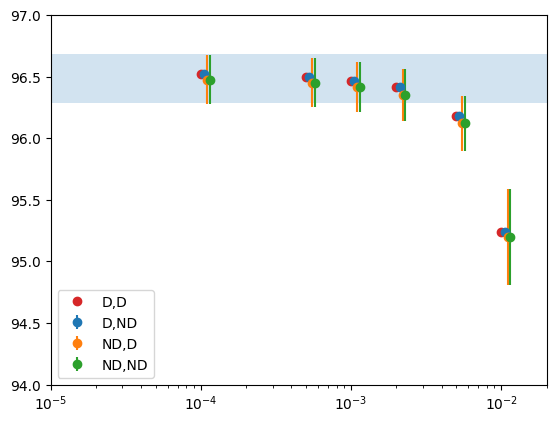

In [51]:
accuracies = np.load("atomic_models/accuracies.npy")
num_epochs=25
num_models_trained=200
num_models=25
accuracies = np.reshape(accuracies, (num_models_trained,num_epochs))

correct_mean = np.mean(accuracies[:num_models,-1])
correct_err = np.std(accuracies[:num_models,-1])


mklabel = lambda t,i: ('D' if t else 'ND') + ',' + ('D' if i else 'ND')
for i, (train,inf) in enumerate([[True,False],[False,True],[False,False]]):
    x,y,err = get_errplt_data(train,inf)
    plt.errorbar(x+(i+1)*0.05*x,y,err,linestyle='None',marker='o', label=mklabel(train,inf))

dI_dT_filter = (data['deterministic_training'] == True) & (data['deterministic_inference'] == True)
xdd,ydd = data[dI_dT_filter][['epsilon','num_correct']].T.values
ydd = np.array([a[0]*100/len(test_loader) for a in ydd])

plt.plot(xdd,ydd,linestyle = 'None', marker='o', label="D,D")
plt.fill_between([0,1], correct_mean-correct_err, correct_mean+correct_err, alpha=0.2)
plt.xscale('log')
plt.xlim(1e-5,2e-2)
plt.legend(loc='lower left')
plt.ylim(94,97)
plt.show()

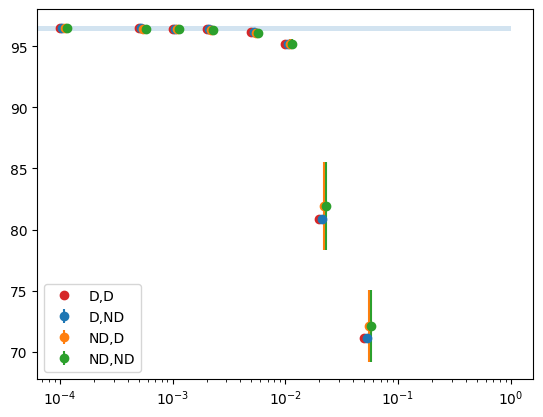

In [52]:
accuracies = np.load("atomic_models/accuracies.npy")
num_epochs=25
num_models_trained=200
num_models=25
accuracies = np.reshape(accuracies, (num_models_trained,num_epochs))

correct_mean = np.mean(accuracies[:num_models,-1])
correct_err = np.std(accuracies[:num_models,-1])


mklabel = lambda t,i: ('D' if t else 'ND') + ',' + ('D' if i else 'ND')
for i, (train,inf) in enumerate([[True,False],[False,True],[False,False]]):
    x,y,err = get_errplt_data(train,inf)
    plt.errorbar(x+(i+1)*0.05*x,y,err,linestyle='None',marker='o', label=mklabel(train,inf))

dI_dT_filter = (data['deterministic_training'] == True) & (data['deterministic_inference'] == True)
xdd,ydd = data[dI_dT_filter][['epsilon','num_correct']].T.values
ydd = np.array([a[0]*100/len(test_loader) for a in ydd])

plt.plot(xdd,ydd,linestyle = 'None', marker='o', label="D,D")
plt.fill_between([0,1], correct_mean-correct_err, correct_mean+correct_err, alpha=0.2)
plt.xscale('log')
plt.legend(loc='lower left')
plt.show()